In [1]:
username = "Alex"
pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`


In [2]:
using StaticArrays, DifferentialEquations, DynamicalSystems

sE, sI, rE, rI, Y  = -50..50, -50..50,  -50..50, -50..50, -50..50
box = sE × sI × rE × rI × Y

using CairoMakie, GLMakie
using LinearAlgebra

In [ ]:
# not optimize

"""function rate_jac(u, p , t)
    sE, sI, rE, rI, Y = u
    τsE, γE, s0E, τsI, γI, s0I, τrE, kE, IE, wEE, wIE, θE, τrI, kI, II, wEI, wII, θI, τY, βY, gammaY, ythr, sEthr, kY = p

    g(Y) = 1.0 + gammaY / (1.0 + exp(-Y + ythr))
    HevY(sE) = 1.0/(1.0 + exp(-(sE - sEthr)/kY))

    sEsE = 1.0/τsE * ( -1.0 - γE * rE *  g(Y))
    sIsE = 0
    rEsE = 1.0/τrE * ( kE * wEE * exp(-kE*( (IE + wEE*sE-wIE*sI) - θE) ) ) / ( 1.0 + exp(-kE*( (IE + wEE*sE-wIE*sI) - θE) ) )^2
    rIsE = 1.0/τrI * ( kI * wEI * exp( -kI*( (II + wEI*sE-wII*sI) - θI) ) ) / ( 1.0 + exp(-kI*((II + wEI*sE-wII*sI) - θI)) )^2
    YsE = (βY * exp( -(sE - sEthr)/kY )) /( ( 1.0 + exp( -(sE - sEthr)/kY ) )^2 * kY)

    sEsI = 0.0
    sIsI = (1.0/τsI) * ( -1.0 - γI * rI  )
    rEsI = (1.0/τrE) * (-kE * wIE * exp(-kE*( (IE + wEE*sE-wIE*sI) - θE) )) / ( 1.0 + exp(-kE*( (IE + wEE*sE-wIE*sI) - θE) ) )^2 
    rIsI = (1.0/τrI) * (-kI * wII * exp( -kI*( (II + wEI*sE-wII*sI) - θI) )) / (1.0 + exp( -kI*( (II + wEI*sE-wII*sI) - θI) ))^2
    YsI = 0.0

    sErE = (1.0/τsE) * ( γE*(1-sE)*g(Y) )
    sIrE = 0.0
    rErE = (-1.0/τrE)
    rIrE = 0.0
    YrE = 0.0

    sErI = 0.0
    sIrI = (1.0/τsI) * ( γI*(1.0-sI) )
    rErI = 0.0
    rIrI = (-1.0/τrI)
    YrI = 0.0

    sEY = (1.0/τsE) * ( γE*rE*(1.0-sE) * ( γY * exp(-Y + ythr) ) / (1.0 + exp(-Y + ythr))^2 )
    sIY = 0.0
    rEY = 0.0
    rIY = 0.0
    YY = (-1.0/τY)

    return SMatrix{5,5}(sEsE, sIsE, rEsE, rIsE, YsE,
    sEsI, sIsI, rEsI, rIsI, YsI,
    sErE, sIrE, rErE, rIrE, YrE,
    sErI, sIrI, rErI, rIrI, YrI,
    sEY, sIY, rEY, rIY, YY)

end"""

In [ ]:
# before vectorization

"""function rate_jac(u, p , t)
    sE, sI, rE, rI, Y = u
    τsE, γE, s0E, τsI, γI, s0I, τrE, kE, IE, wEE, wIE, θE, τrI, kI, II, wEI, wII, θI, τY, βY, gammaY, ythr, sEthr, kY = p

    gY = 1.0 + gammaY / (1.0 + exp(-Y + ythr))
    HevY = 1.0/(1.0 + exp(-(sE - sEthr)/kY))

    expE = exp(-kE*( (IE + wEE*sE-wIE*sI) - θE) )
    expI = exp( -kI*( (II + wEI*sE-wII*sI) - θI) )
    expHev = exp( -(sE - sEthr)/kY )
    expY = exp(-Y + ythr)


    sEsE = 1.0/τsE * (-1.0 - γE * rE *  gY)
    #sIsE = 0.0
    rEsE = 1.0/τrE * (kE * wEE * expE) / (1.0 + expE)^2
    rIsE = 1.0/τrI * (kI * wEI * expI) / (1.0 + expI)^2
    YsE = (βY * expHev) / ((1.0 + expHev)^2 * kY)

    #sEsI = 0.0
    sIsI = (1.0/τsI) * (-1.0 - γI * rI )
    rEsI = (1.0/τrE) * (-kE * wIE * expE) / (1.0 + expE)^2 
    rIsI = (1.0/τrI) * (-kI * wII * expI) / (1.0 + expI)^2
    YsI = 0.0

    sErE = (1.0/τsE) * ( γE*(1-sE)*gY )
    #sIrE = 0.0
    rErE = (-1.0/τrE)
    #rIrE = 0.0
    #YrE = 0.0

    #sErI = 0.0
    sIrI = (1.0/τsI) * ( γI*(1.0-sI) )
    #rErI = 0.0
    rIrI = (-1.0/τrI)
    #YrI = 0.0

    sEY = (1.0/τsE) * ( γE*rE*(1.0-sE) * ( γY * expY ) / (1.0 + expY )^2 )
    #sIY = 0.0
    #rEY = 0.0
    #rIY = 0.0
    YY = (-1.0/τY)

    return SMatrix{5,5}(sEsE, 0.0, rEsE, rIsE, YsE,
    0.0, sIsI, rEsI, rIsI, 0.0,
    sErE, 0.0, rErE, 0.0, 0.0,
    0.0, sIrI, 0.0, rIrI, 0.0,
    sEY, 0.0, 0.0, 0.0, YY)

end"""

In [3]:
function model_braint_rhythms(u, p, t)

    sE, sI, rE, rI, Y = u
    τsE, γE, s0E, τsI, γI, s0I, τrE, kE, IE, wEE, wIE, θE, τrI, kI, II, wEI, wII, θI, τY, βY, gammaY, ythr, sEthr, kY = p

    g(Y) = 1.0 + gammaY / (1.0 + exp(-Y + ythr))
    HevY(sE) = 1.0/(1.0 + exp(-(sE - sEthr)/kY))

    dsEdt = (1/τsE) *(-sE + γE*rE*(1-sE)*g(Y) + s0E)
    dsIdt = (1/τsI) *(-sI + γI*rI*(1-sI) + s0I)

    drEdt = (1/ τrE) *(-rE + 1/(1 + exp(-kE*((IE + wEE*sE-wIE*sI) - θE))))
    drIdt = (1/τrI) *(-rI + 1/(1 + exp(-kI*((II + wEI*sE-wII*sI) - θI))))
    
    dYdt = -Y / τY + βY * HevY(sE)  
    
    return SVector(dsEdt, dsIdt, drEdt, drIdt, dYdt)
    
end

function rate_jac(u, p , t)
    
    #sE, sI, rE, rI, Y = u
    τsE, γE, s0E, τsI, γI, s0I, τrE, kE, IE, wEE, wIE, θE, τrI, kI, II, wEI, wII, θI, τY, βY, gammaY, ythr, sEthr, kY = p

    gY = 1.0 + gammaY / (1.0 + exp(-u[5] + ythr))
    HevY = 1.0/(1.0 + exp(-(u[1] - sEthr)/kY))

    expE = exp(-kE*( (IE + wEE*u[1]-wIE*u[2]) - θE) )
    expI = exp( -kI*( (II + wEI*u[1]-wII*u[2]) - θI) )
    expHev = exp( -(u[1] - sEthr)/kY )
    expY = exp(-u[5] + ythr)


    sEsE = 1.0/τsE * (-1.0 - γE * u[3] *  gY)
    #sIsE = 0.0
    rEsE = 1.0/τrE * (kE * wEE * expE) / (1.0 + expE)^2
    rIsE = 1.0/τrI * (kI * wEI * expI) / (1.0 + expI)^2
    YsE = (βY * expHev) / ((1.0 + expHev)^2 * kY)

    #sEsI = 0.0
    sIsI = (1.0/τsI) * (-1.0 - γI * u[4] )
    rEsI = (1.0/τrE) * (-kE * wIE * expE) / (1.0 + expE)^2 
    rIsI = (1.0/τrI) * (-kI * wII * expI) / (1.0 + expI)^2
    #YsI = 0.0

    sErE = (1.0/τsE) * ( γE*(1-u[1])*gY )
    #sIrE = 0.0
    rErE = (-1.0/τrE)
    #rIrE = 0.0
    #YrE = 0.0

    #sErI = 0.0
    sIrI = (1.0/τsI) * ( γI*(1.0-u[2]) )
    #rErI = 0.0
    rIrI = (-1.0/τrI)
    #YrI = 0.0

    sEY = (1.0/τsE) * ( γE*u[3]*(1.0-u[1]) * ( γY * expY ) / (1.0 + expY )^2 )
    #sIY = 0.0
    #rEY = 0.0
    #rIY = 0.0
    YY = (-1.0/τY)

    return SMatrix{5,5}(sEsE, 0.0, rEsE, rIsE, YsE,
    0.0, sIsI, rEsI, rIsI, 0.0,
    sErE, 0.0, rErE, 0.0, 0.0,
    0.0, sIrI, 0.0, rIrI, 0.0,
    sEY, 0.0, 0.0, 0.0, YY)

end

function show_fp(fp, names)
    for (index, fp_) in enumerate(fp)
        println("$(index) - fp:")
        for (i, cord) in enumerate(fp_)
                println("$(names[i]): $cord")
        end
    end
end
function show_eigenvalues(ei)
    for (index, ei_) in enumerate(ei)
        println("$(index) - fp:")
        for (i, ei__) in enumerate(ei_)
            println("$ei__")
        end
    end
end
names = ["sE", "sI", "rE", "rI", "Y"];

In [4]:
time = 1000; tt = 0.0; tstep = 0.001; times = [time, tt]
integ_set = (alg = Vern9(), adaptive = false, dt = tstep);

In [45]:
τsE = 3.0; γE = 4.0; s0E = 0.15;
τsI = 10.0; γI = 8.0; s0I = 0.1;

τrE = 2.0; kE = 5.0; IE = 2.2566039; wEE = 3.5; wIE = 5.0; θE = 0.2;
τrI = 6.0; kI = 5.0; II = 0.0; wEI = 5.0; wII = 3.0; θI = 0.4;

τY = 0.01;  βY = 0.01;  γY = -0.52430801; 
ythr = 0.5; sEthr = 0.5; kY = 0.01

p = [τsE, γE, s0E, τsI, γI, s0I, τrE, kE, IE, wEE, wIE, θE, τrI, kI, II, wEI, wII, θI, τY, βY, γY, ythr, sEthr, kY];

u0 = [0.0, 0.0, 0.0, 0.0, 0.0]

ds = CoupledODEs(model_braint_rhythms, u0, p, diffeq = integ_set)

5-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  model_braint_rhythms
 ODE solver:    Vern9
 ODE kwargs:    (adaptive = false, dt = 0.001)
 parameters:    [3.0, 4.0, 0.15, 10.0, 8.0, 0.1, 2.0, 5.0, 2.2566039, 3.5  …  0.0, 5.0, 3.0, 0.4, 0.01, 0.01, -0.52430801, 0.5, 0.5, 0.01]
 time:          0.0
 state:         [0.0, 0.0, 0.0, 0.0, 0.0]


In [46]:
fp, ei, _ = fixedpoints(ds, box, rate_jac)

show_fp(fp, names)
println("")
show_eigenvalues(ei)

1 - fp:
sE: 0.7057015819815162
sI: 0.8909897160951794
rE: 0.5885693492041981
rI: 0.9070127236640015
Y: 9.999999988345497e-5
2 - fp:
sE: 0.6971766905069666
sI: 0.8891739600462224
rE: 0.5632253881954232
rI: 0.8901043928567736
Y: 9.99999997266462e-5
3 - fp:
sE: 0.696726092721456
sI: 0.8890698437308333
rE: 0.5619254354462314
rI: 0.8891516408488974
Y: 9.999999971404721e-5

1 - fp:
-99.99999999999964 + 0.0im
-1.5635683727267815 + 0.0im
-0.8589440455430497 + 0.0im
-0.02451901198654199 + 0.0im
-0.007987027209884102 + 0.0im
2 - fp:
-99.99999999999922 + 0.0im
-1.5608737028472321 + 0.0im
-0.8526971428748883 + 0.0im
-0.0035945879243847985 + 0.0im
0.002776137568488543 + 0.0im
3 - fp:
-99.9999999999992 + 0.0im
-1.5606899546016515 + 0.0im
-0.8523484313295328 + 0.0im
0.0004007218691321863 - 0.003217690371286555im
0.0004007218691321863 + 0.003217690371286555im


In [39]:
index_fp = 1
index_vec = 5
ϵ = 1e-7

Jac = rate_jac(fp[index_fp], p, 0)

eivecs = eigvecs(Jac)

shift =  fp[index_fp] + real(eivecs[:, index_vec])*ϵ

ds = CoupledODEs(model_braint_rhythms, shift, p, diffeq = (alg = RK4(), adaptive = false, dt = tstep))

5-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  model_braint_rhythms
 ODE solver:    RK4
 ODE kwargs:    (adaptive = false, dt = 0.001)
 parameters:    [3.0, 4.0, -1.5535255, 10.0, 8.0, 0.1, 2.0, 5.0, 0.9, 3.5  …  0.0, 5.0, 3.0, 0.4, 0.01, 0.01, 0.305, 0.5, 0.5, 0.01]
 time:          0.0
 state:         [-1.553525499951717, 0.10000010000000001, 4.238976047149959e-12, 4.100003101564359e-19, -1.3247518451720553e-50]


In [40]:
tr, trange = trajectory(ds, time*2, Δt = tstep)

(5-dimensional StateSpaceSet{Float64} with 2000001 points, 0.0:0.001:2000.0)

In [41]:
tickssize = 30; labelsize = 35

35

In [42]:
indexx, indexy, indexz = 3, 1, 2
tstart, tend = 1, 1500000
GLMakie.activate!()
f = Figure(resolution = (700, 700))
ax = LScene(f[1, 1], show_axis = true)
scale!(ax.scene, 1, 1, 1)
lines!(ax, tr[tstart:tend, indexx], tr[tstart:tend, indexy], tr[tstart:tend, indexz], linewidth = 1.0, color = :deeppink)

for fp_ in fp
    scatter!(ax, fp_[indexx], fp_[indexy], fp_[indexz], markersize = 12.0)
end
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

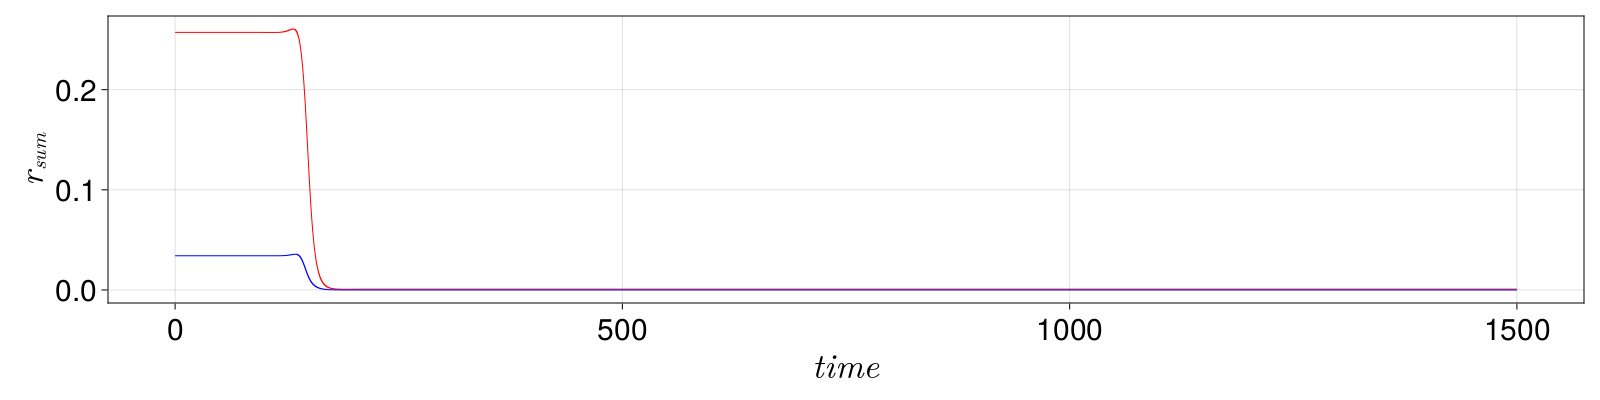

CairoMakie.Screen{IMAGE}


In [802]:
CairoMakie.activate!()
f= Figure(resolution = (1600, 400))
axisrHz  = Axis(f[1, 1], xlabel = L"time", ylabel = L"r_{sum}", xlabelsize = labelsize, ylabelsize = labelsize, xticklabelsize = tickssize, yticklabelsize = tickssize, xgridvisible = true, ygridvisible = true)

lines!(axisrHz, trange[tstart:tend], tr[tstart:tend, 3], linewidth = 1.0, color = :red)
lines!(axisrHz, trange[tstart:tend], tr[tstart:tend, 4], linewidth = 1.0, color = :blue)

display(f)

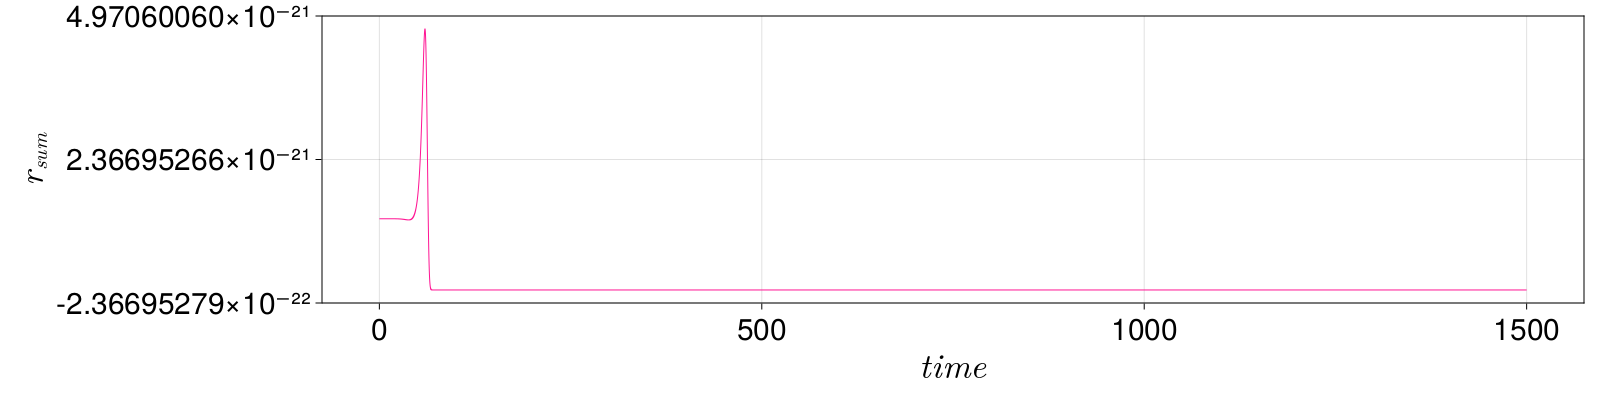

CairoMakie.Screen{IMAGE}


In [752]:
CairoMakie.activate!()
f= Figure(resolution = (1600, 400))
axisrHz  = Axis(f[1, 1], xlabel = L"time", ylabel = L"r_{sum}", xlabelsize = labelsize, ylabelsize = labelsize, xticklabelsize = tickssize, yticklabelsize = tickssize, xgridvisible = true, ygridvisible = true)

lines!(axisrHz, trange[tstart:tend], tr[tstart:tend, 5], linewidth = 1.0, color = :deeppink)

display(f)